\begin{center}
Chun-Yuan (Scott) Chiu
\end{center}
\begin{center}
chunyuac@andrew.cmu.edu
\end{center}

# Question One {-}

Reading data in and show the first few data points: 

In [1]:
import pandas as pd

bonds = pd.read_csv('bonds.txt', sep='\t', index_col=0)
# bonds = bonds[bonds['CouponRate'] > 6]
n = len(bonds)

bonds.head()

,CouponRate,BidPrice
Case,,
1,7.000,92.94
2,9.000,101.44
3,7.000,92.66
4,4.125,94.50
5,13.125,118.94


There are 35 data points. 

In [2]:
n

35

## 1. {-}

The below figure suggests that there might be outliers for low coupon Rates. Linear regression model does not fit the data very well. 

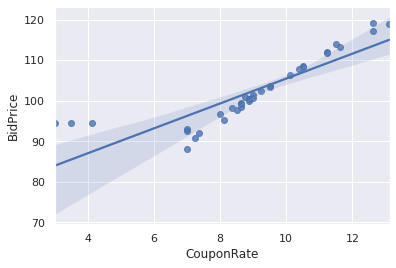

In [3]:
import seaborn as sns

sns.set_theme(color_codes=True)
ax = sns.regplot(x='CouponRate', y='BidPrice', data=bonds)

## 2. {-}

See below for the summary of the fitted model. 

In [4]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

olsBonds = sm.OLS.from_formula(formula='BidPrice ~ CouponRate', data=bonds).fit()
olsBonds.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               BidPrice   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     99.87
Date:                Thu, 15 Oct 2020   Prob (F-statistic):           1.64e-11
Time:                        07:04:39   Log-Likelihood:                -98.656
No. Observations:                  35   AIC:                             201.3
Df Residuals:                      33   BIC:                             204.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     74.7866      2.827     26.458      0.000      69.036      80.537
CouponRate     3.0661      0.307      9.994      0.000       2.442       3.690
==============================================================================
Omnibus:                        3.313   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.191   Jarque-Bera (JB):                2.262
Skew:                           0.607   Prob(JB):                        0.323
Kurtosis:                       3.276   Cond. No.                         37.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3. {-}

We see clear pattern in the plot of residuals versus fitted values, suggesting the linear model is not adequate. 

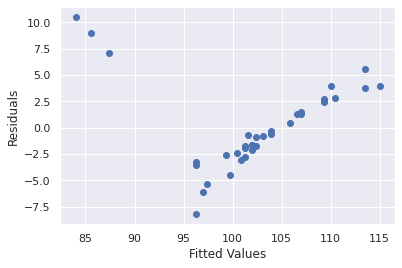

In [5]:
plt.scatter(olsBonds.fittedvalues, olsBonds.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

## 4. {-}

Recall that the 95% confidence interval is $\hat\beta_1 \pm z_{0.025}\text{SE}(\hat \beta_1)$, where the standard error is 
$$
\text{SE}(\hat\beta_1)\approx\frac{\hat\sigma}{s_x\sqrt{n-1}}
$$
and
$$
\hat\sigma^2 = \text{RSS}/(n-2). 
$$
Below is the numerical value. Here the normal distribution is used. If we use t-distribution instead, the value will match the ones in the summary. As $n>30$, the differences are tiny. 

In [6]:
import numpy as np
from scipy.stats import norm, t

se = np.sqrt(olsBonds.ssr/(n-2))/(np.std(bonds['CouponRate'], ddof=1)*np.sqrt(n-1))
# z = t.ppf(1 - 0.025, n-2)
z = norm.ppf(1 - 0.025)

(olsBonds.params['CouponRate'] - (z*se), olsBonds.params['CouponRate'] + (z*se))

(2.464778252846198, 3.6674260585957033)

The CI derivation is based on the assumption the linear model is adequate, which is not the case for the data set here. In this case, the confidence interval is not meaningful. 

# Question Two {-}

## 1. {-}

Read in the data and drop the ```id``` and ```bond_id``` columns which clearly have no predictive power. 

In [7]:
data = pd.read_csv('bonddata.txt', sep=',')
data.head()

,id,bond_id,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,...,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,10,1,126.268,7.616851,5.950,25.940349,0,12.540,150000.0,3,...,2862729,128.596,120000.0,2,127.561201,3621492,129.089,200000.0,2,129.435587
1,38,2,101.009,0.018373,3.550,0.326392,0,9.327,450000.0,3,...,532644,101.086,500000.0,2,101.103180,538510,101.070,25000.0,2,101.102243
2,336,3,108.144,3.537380,4.200,2.340601,0,0.102,160000.0,4,...,96293,107.917,400000.0,2,107.874965,96293,107.917,400000.0,4,107.874965
3,781,4,116.953,0.402523,4.875,7.367653,0,52.093,10000.0,4,...,92559,115.924,10000.0,2,116.160420,97177,116.458,2000.0,3,116.342802
4,1172,14,133.210,0.210685,10.750,4.159301,0,13.722,25000.0,4,...,6400208,127.500,25000.0,2,131.066998,6400208,127.500,25000.0,4,131.066998


In [9]:
data.drop(['bond_id', 'id'], axis='columns', inplace=True)

From the nature of the data, ```is_callable``` and any column with type in the column name is categorical. 

In [10]:
import pandas as pd

catCols = ['is_callable'] + [colName for colName in data.columns if 'type' in colName]


### won't make a difference as get_dummies will automatically categorize the input columns
# for colName in catCols: 
#     data[colName] = data[colName].astype('category')


data = pd.get_dummies(data=data, columns=catCols)

In [11]:
import statsmodels.api as sm

X = sm.add_constant(data.drop('trade_price', axis='columns'))

fullmod = sm.OLS(endog=data['trade_price'], exog=X).fit()

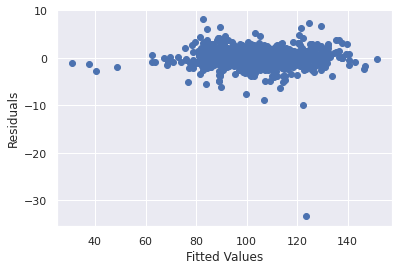

In [12]:
plt.scatter(fullmod.fittedvalues, fullmod.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

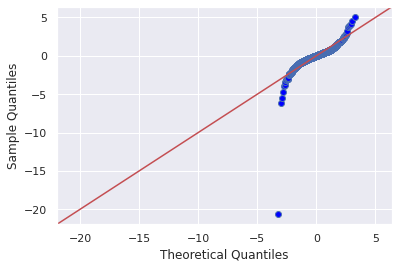

In [13]:
from statsmodels.graphics.gofplots import qqplot

qqplot(fullmod.resid, dist=norm, line='45', fit=True)
plt.show()

In [14]:
X

,const,weight,current_coupon,time_to_maturity,reporting_delay,trade_size,curve_based_price,received_time_diff_last1,trade_price_last1,trade_size_last1,...,trade_type_last7_4,trade_type_last8_2,trade_type_last8_3,trade_type_last8_4,trade_type_last9_2,trade_type_last9_3,trade_type_last9_4,trade_type_last10_2,trade_type_last10_3,trade_type_last10_4
0,1.0,7.616851,5.95000,25.940349,12.540,150000.0,126.017363,343747,125.101,400000.0,...,0,0,0,1,1,0,0,1,0,0
1,1.0,0.018373,3.55000,0.326392,9.327,450000.0,101.068546,1,101.009,450000.0,...,0,1,0,0,1,0,0,1,0,0
2,1.0,3.537380,4.20000,2.340601,0.102,160000.0,107.927659,74139,107.990,6000.0,...,0,1,0,0,1,0,0,0,0,1
3,1.0,0.402523,4.87500,7.367653,52.093,10000.0,116.552464,959,115.842,5000.0,...,1,1,0,0,1,0,0,0,1,0
4,1.0,0.210685,10.75000,4.159301,13.722,25000.0,130.202417,262,133.612,25000.0,...,1,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,1.0,0.018373,5.95000,25.469243,0.638,5000.0,117.747938,1,116.407,5000.0,...,0,0,1,0,0,0,1,0,1,0
1616,1.0,3.151100,9.25000,3.034136,16.014,575000.0,101.400020,58831,101.520,273000.0,...,0,0,0,1,1,0,0,1,0,0
1617,1.0,8.477502,0.72625,2.527172,26.003,682000.0,94.987898,425818,92.000,29000.0,...,0,1,0,0,1,0,0,0,0,1
1618,1.0,3.830211,6.25000,5.444478,68.501,5000000.0,105.900870,86922,105.419,5000000.0,...,0,1,0,0,0,0,1,0,1,0


In [15]:
X.drop(['const'], axis='columns', inplace=True)

In [18]:
from statsmodels.stats import outliers_influence

def AIC(model):
    return model.aic

def PRESS(model):
    levs = outliers_influence.OLSInfluence(model).hat_matrix_diag
    return ((model.resid/(1 - levs))**2).sum()
    
def modelSelection(endog, exog, selectionMethod=AIC):
    '''
    Assuming no constant column in the input exog 
    '''
    chosen = []
    remaining = list(exog.columns.values)
    best = np.inf

    for i in range(len(X.columns)):
        idx_quantities = [(idx, selectionMethod(sm.OLS(endog, exog=sm.add_constant(exog[[feature] + chosen])).fit())) for idx, feature in enumerate(remaining)]
        idx, q = min(idx_quantities, key=lambda idx_q: idx_q[1])
        if q >= best:
            break
        best = q
        chosen.append(remaining[idx])
        remaining = remaining[:idx] + remaining[idx+1:]
    
    return chosen


chosenAIC = modelSelection(endog=data['trade_price'], exog=X, selectionMethod=AIC)
chosenPRESS = modelSelection(endog=data['trade_price'], exog=X, selectionMethod=PRESS)

chosenAIC, chosenPRESS

(['trade_price_last1',
  'curve_based_price',
  'trade_type_2',
  'trade_price_last7',
  'trade_type_3',
  'trade_price_last10',
  'trade_price_last4',
  'curve_based_price_last5',
  'trade_type_last1_3',
  'trade_type_last4_3',
  'trade_type_last4_2',
  'trade_type_last1_2',
  'trade_price_last9',
  'trade_type_last9_2',
  'curve_based_price_last1',
  'curve_based_price_last4',
  'curve_based_price_last3',
  'received_time_diff_last10',
  'trade_type_last5_3',
  'trade_price_last3',
  'is_callable_1',
  'reporting_delay'],
 ['trade_price_last1',
  'curve_based_price',
  'trade_type_2',
  'trade_price_last7',
  'trade_type_4',
  'trade_price_last10',
  'trade_type_last1_3',
  'curve_based_price_last5',
  'trade_price_last4',
  'trade_type_last4_3',
  'trade_type_last1_2',
  'trade_type_last4_2',
  'trade_size_last7',
  'is_callable_1',
  'trade_size',
  'received_time_diff_last10',
  'trade_price_last9',
  'trade_type_last9_2',
  'reporting_delay',
  'trade_type_last5_3',
  'received_t

In [19]:
chosenAIC = ['trade_price_last1', 'curve_based_price', 'trade_type_2', 'trade_price_last7', 'trade_type_3', 'trade_price_last10', 'trade_price_last4', 'curve_based_price_last5', 'trade_type_last1_3', 'trade_type_last4_3', 'trade_type_last4_2', 'trade_type_last1_2', 'trade_price_last9', 'trade_type_last9_2', 'curve_based_price_last1', 'curve_based_price_last4', 'curve_based_price_last3', 'received_time_diff_last10', 'trade_type_last5_3', 'trade_price_last3', 'is_callable_1', 'reporting_delay']
chosenPRESS = ['trade_price_last1', 'curve_based_price', 'trade_type_2', 'trade_price_last7', 'trade_type_4', 'trade_price_last10', 'trade_type_last1_3', 'curve_based_price_last5', 'trade_price_last4', 'trade_type_last4_3', 'trade_type_last1_2', 'trade_type_last4_2', 'trade_size_last7', 'is_callable_1', 'trade_size', 'received_time_diff_last10', 'trade_price_last9', 'trade_type_last9_2', 'reporting_delay', 'trade_type_last5_3', 'received_time_diff_last8', 'trade_size_last4', 'trade_size_last5', 'trade_type_last1_4', 'trade_type_3'] 

In [21]:
len(set(chosenAIC) & set(chosenPRESS))

18

In [25]:
modAIC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            trade_price   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     3527.
Date:                Thu, 15 Oct 2020   Prob (F-statistic):               0.00
Time:                        07:27:46   Log-Likelihood:                -3092.3
No. Observations:                1620   AIC:                             6231.
Df Residuals:                    1597   BIC:                             6355.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.2270      0.452      2.713      0.007       0.340       2.114
trade_price_last1             0.4340      0.028     15.456      0.000       0.379       0.489
curve_based_price             0.3929      0.038     10.296      0.000       0.318       0.468
trade_type_2                 -0.8080      0.100     -8.112      0.000      -1.003      -0.613
trade_price_last7             0.1129      0.023      4.843      0.000       0.067       0.159
trade_type_3                  0.8038      0.100      8.027      0.000       0.607       1.000
trade_price_last10            0.0376      0.026      1.422      0.155      -0.014       0.090
trade_price_last4             0.1033      0.030      3.392      0.001       0.044       0.163
curve_based_price_last5      -0.2031      0.050     -4.037      0.000      -0.302      -0.104
trade_type_last1_3           -0.2174      0.100     -2.169      0.030      -0.414      -0.021
trade_type_last4_3           -0.2073      0.103     -2.017      0.044      -0.409      -0.006
trade_type_last4_2            0.2007      0.104      1.929      0.054      -0.003       0.405
trade_type_last1_2            0.2293      0.106      2.157      0.031       0.021       0.438
trade_price_last9             0.0763      0.029      2.641      0.008       0.020       0.133
trade_type_last9_2            0.1874      0.100      1.883      0.060      -0.008       0.383
curve_based_price_last1      -0.0607      0.051     -1.180      0.238      -0.162       0.040
curve_based_price_last4       0.2077      0.074      2.795      0.005       0.062       0.354
curve_based_price_last3      -0.1591      0.066     -2.419      0.016      -0.288      -0.030
received_time_diff_last10 -3.692e-08   2.06e-08     -1.791      0.074   -7.74e-08    3.52e-09
trade_type_last5_3           -0.1440      0.088     -1.628      0.104      -0.317       0.029
trade_price_last3             0.0469      0.031      1.534      0.125      -0.013       0.107
is_callable_1                 0.1791      0.120      1.498      0.134      -0.055       0.413
reporting_delay            -1.75e-06   1.22e-06     -1.429      0.153   -4.15e-06    6.53e-07
==============================================================================
Omnibus:                     1930.311   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           907009.858
Skew:                          -5.538   Prob(JB):                         0.00
Kurtosis:                     118.389   Cond. No.                     3.10e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.1e+07. This might indicate t

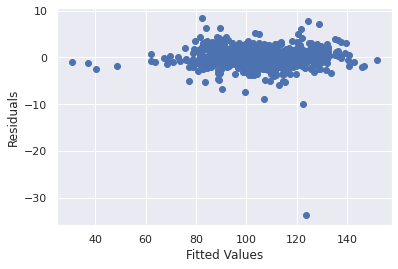

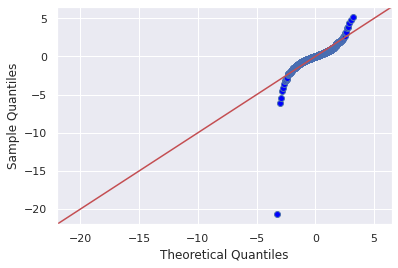

In [29]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

model = sm.OLS(endog=data['trade_price'], exog=sm.add_constant(X[chosenAIC])).fit()

plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

qqplot(modAIC.resid, dist=norm, line='45', fit=True)
plt.show()

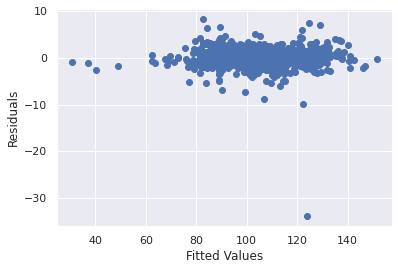

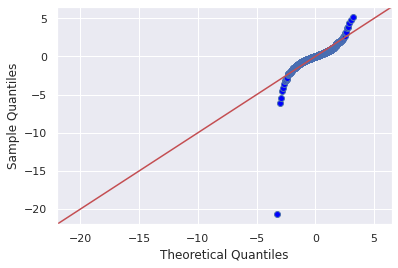

In [28]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

model = sm.OLS(endog=data['trade_price'], exog=sm.add_constant(X[chosenPRESS])).fit()

plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

qqplot(modAIC.resid, dist=norm, line='45', fit=True)
plt.show()